In [1]:
import numpy as np
from ase.io import read

from abtem.waves import Waves, PlaneWave, Probe
from abtem.potentials.temperature import FrozenPhonons
from abtem.potentials import Potential
from abtem import GridScan, AnnularDetector

# abTEM and Dask

Parallel computation in abTEM whether it is running on laptop, a GPU or on a High Performance Computing cluster goes through Dask. Basic knowledge of Dask may be required to run abTEM effectively on large multi-CPU/GPU systems, however, if you are just running abTEM on your own computer, this short tutorial should suffice.

## Delayed computations

Computations in abTEM are _delayed_ (or sometimes called _lazy_) by default, this means that "building" the probe wave function only creates the instructions for making that probe.

In [2]:
probe = Probe(energy=80e3, extent=10, gpts=128, semiangle_cutoff=30)

build_probe = probe.build()

build_probe.array

dask.array<ifft2, shape=(1, 128, 128), dtype=complex64, chunksize=(1, 128, 128), chunktype=numpy.ndarray>

If you want the numpy array you have to compute the probe.

In [3]:
computed_probe = build_probe.compute()

computed_probe.array

array([[[-3.3935801e-05+0.0000000e+00j, -3.2977870e-05+2.1849189e-12j,
         -3.0168439e-05-1.1368684e-12j, ...,
         -2.5695779e-05+1.5069202e-12j, -3.0168418e-05+1.4766996e-12j,
         -3.2977867e-05+2.5037821e-12j],
        [-3.2977863e-05-2.8421709e-13j, -3.2041364e-05+2.7853275e-12j,
         -2.9295050e-05-2.0747848e-12j, ...,
         -2.4923746e-05+1.7621460e-12j, -2.9295030e-05+2.0750127e-12j,
         -3.2041353e-05+2.5695921e-12j],
        [-3.0168419e-05+0.0000000e+00j, -2.9295037e-05+3.5242920e-12j,
         -2.6734613e-05-3.2969183e-12j, ...,
         -2.2661752e-05+2.2168933e-12j, -2.6734593e-05+2.7855554e-12j,
         -2.9295034e-05+3.3369783e-12j],
        ...,
        [-2.5695770e-05+2.7666210e-13j, -2.4923744e-05+5.8809554e-13j,
         -2.2661761e-05+1.8550912e-12j, ...,
         -1.9067944e-05+3.9339392e-13j, -2.2661741e-05-6.8902962e-13j,
         -2.4923740e-05+1.5651911e-13j],
        [-3.0168412e-05+6.6596210e-14j, -2.9295030e-05+8.1004355e-13j,
    

An advantage of using Dask is that you can create your task graph first, and then decide when to compute. For example, below we create a task graph for running the multislice algorithm for probe wave functions with starting conditions given by a gridscan.

In [5]:
atoms = read('data/orthogonal_graphene.cif') 

gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=probe.ctf.nyquist_sampling * .9)

probe = Probe(energy=80e3, semiangle_cutoff=30, sampling=.05)

exit_waves = probe.multislice(atoms, gridscan)

exit_waves.array

dask.array<_multislice, shape=(8, 14, 148, 171), dtype=complex64, chunksize=(8, 14, 148, 171), chunktype=numpy.ndarray>

The big 4D array, representing the grid of wave functions, is not in your memory, but if needed you could compute it. However, usually you would apply the effect of the detector, which in STEM, will significantly reduce the size of your result.

In [6]:
diffraction_patterns = exit_waves.diffraction_patterns()
measurement = diffraction_patterns.integrate_annular_disc(50, 150)
measurement.array

dask.array<integrate_fourier_space, shape=(8, 14), dtype=float32, chunksize=(8, 14), chunktype=numpy.ndarray>

It is important to note that Dask, once running the computation, will optimize it such that your computer at no time has all the wave functions in memory (unless you have enough memory).

In [7]:
measurement.compute()

We can show the result by calling show.

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x221498a1a00>)

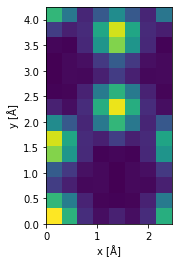

In [8]:
measurement.show()

## Computational graph

Below we show a Dask task graph for creating a probe wave function and shifting it to a particular position.

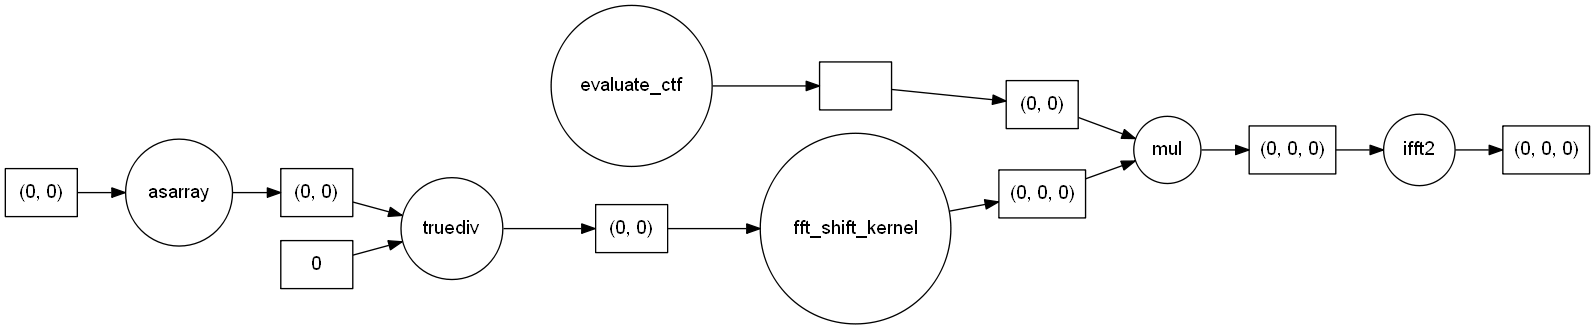

In [9]:
position = (1, 1)
probe.build(position).array.visualize(rankdir='LR')

Real simulations will create bigger taks graphs. We create a STEM-HAADF simulation below:

In [10]:
atoms = read('data/orthogonal_graphene.cif') 

probe = Probe(energy=80e3, semiangle_cutoff=30)

potential = Potential(atoms, sampling=.025, projection='infinite', slice_thickness=2)

detector = AnnularDetector(inner=86, outer=190)

gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=probe.ctf.nyquist_sampling * .9)

image = probe.scan(gridscan, [detector], potential)

The result is a delayed Dask array:

In [11]:
image.array

dask.array<integrate_fourier_space, shape=(8, 14), dtype=float32, chunksize=(8, 12), chunktype=numpy.ndarray>

We can show the tak task graph as below:

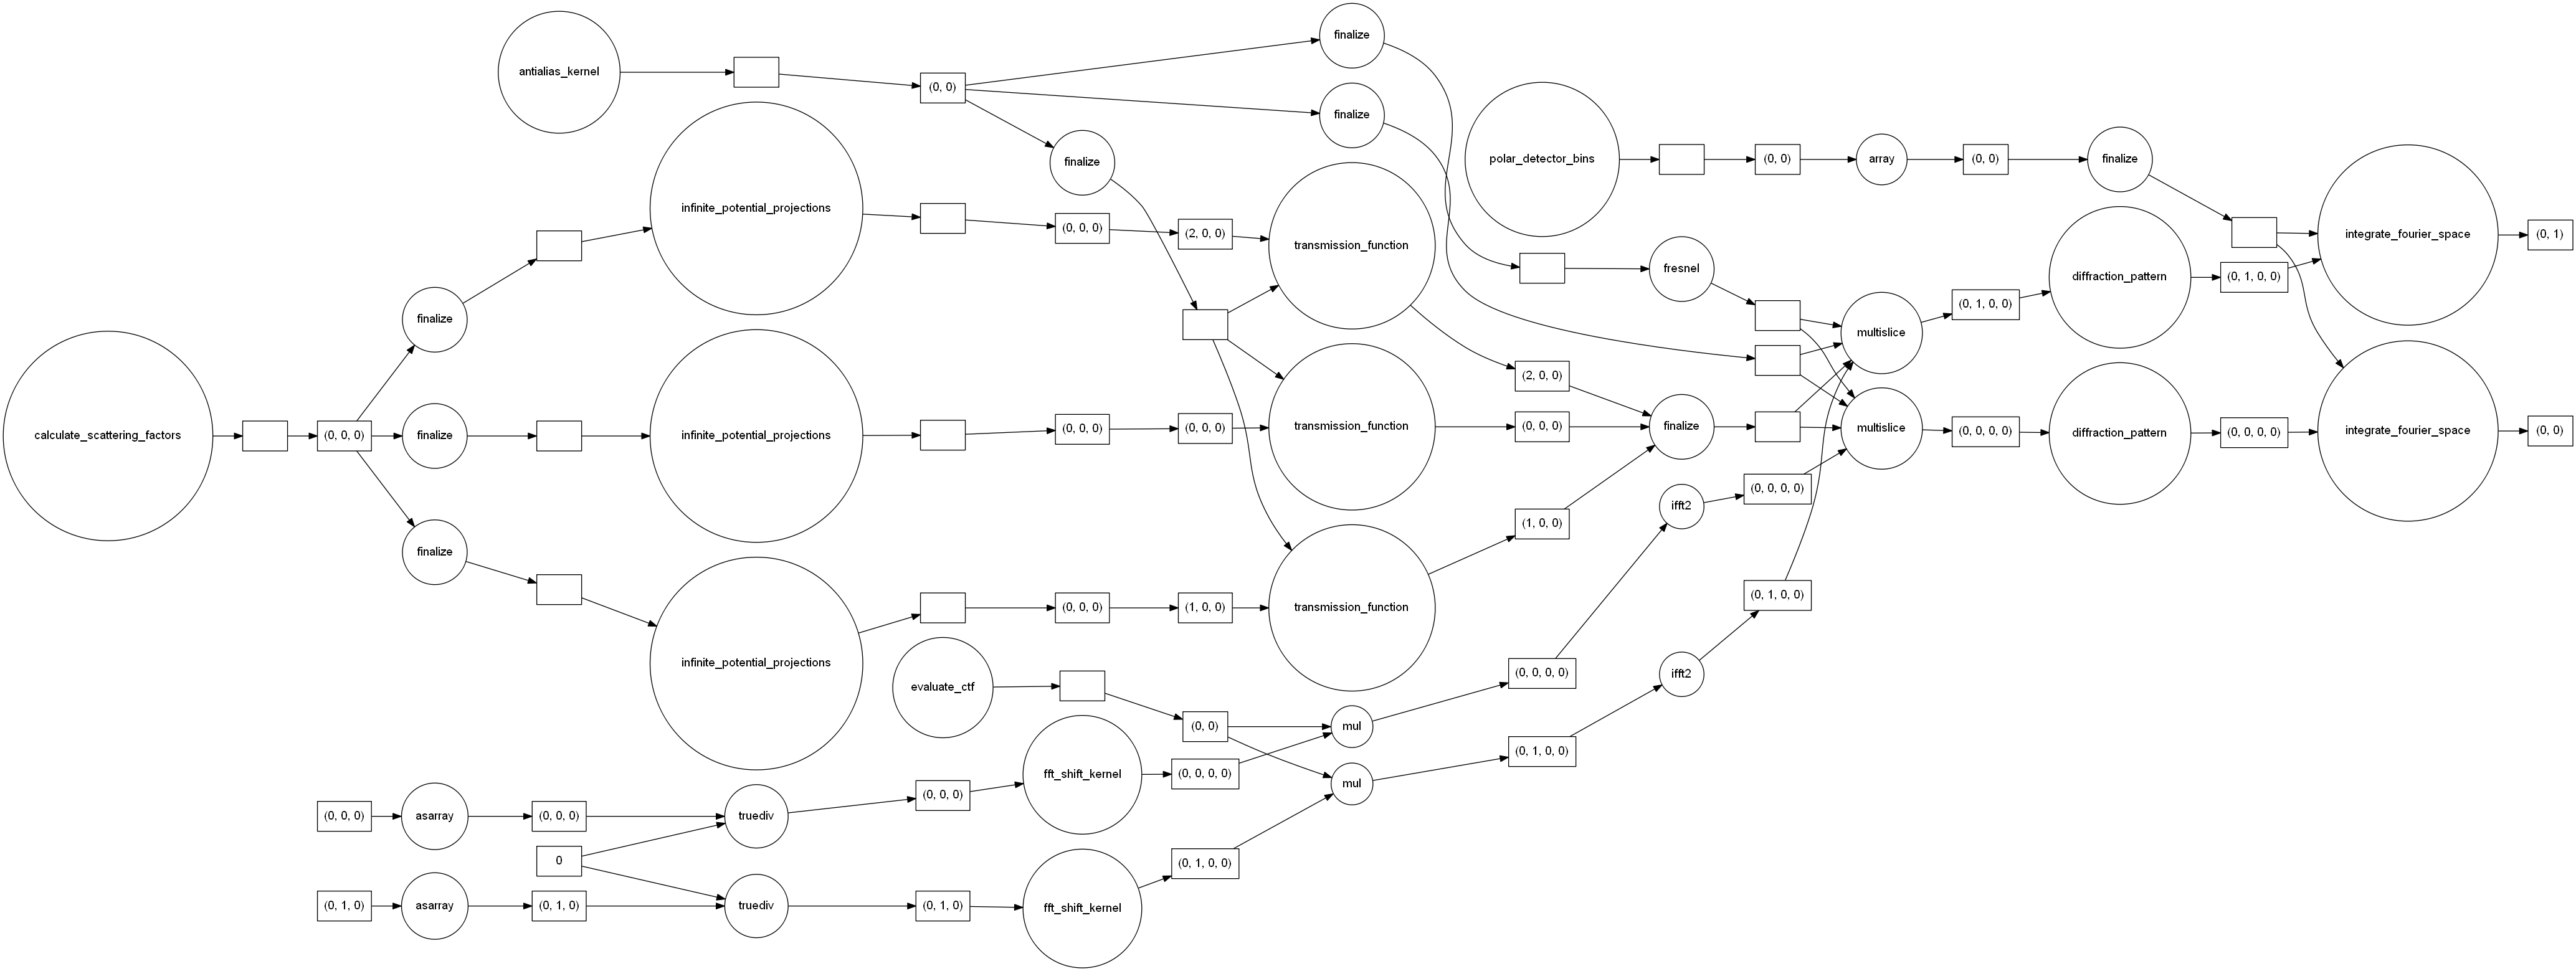

In [12]:
image.visualize_graph(rankdir='LR')

Finally, to run the calculation by calling compute.

In [13]:
image.compute()

We can then wshow our result.

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x2214869f730>)

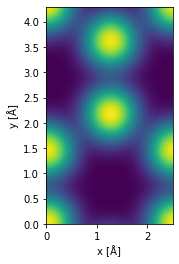

In [14]:
image.interpolate(.05).show()